
## NSFW Image Detector (Male Genital Shaped Items)


Prototype main objective: able to classify positive or negative images to accuracy above 50%

- Binary classification task

### Import related libraries

In [1]:
#import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers

# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
from packaging import version

## 1. Load dataset and carry out pretraining processing for TensorFlow input pipeline

In [2]:
# import datat from .npy, labeled as one or zero
one_data = np.load('../192-144/1_output.npy')
one_label = np.load('../192-144/1_labels.npy')
zero_data = np.load('../192-144/0_output.npy')
zero_label = np.load('../192-144/0_labels.npy')

In [3]:
# check shape and data of one_data which should be 112,693 rows by 1D array of 82,944 (192 x 192 x 3). Image data in 
print("Shape: " ,one_data.shape)
print("Data type: ", one_data.dtype)
print("Data view: ", one_data[1])

Shape:  (112693, 82944)
Data type:  uint8
Data view:  [69 62 69 ... 27 61 99]


In [4]:
#reshape 1D array into 192 x 192 x 3
one_data = one_data.reshape(len(one_data), 192, 144, 3)
zero_data = zero_data.reshape(len(zero_data), 192, 144, 3)

In [5]:
# create tf.data.Dataset object 
one_data = tf.data.Dataset.from_tensor_slices((one_data, one_label))
zero_data = tf.data.Dataset.from_tensor_slices((zero_data, zero_label))

# verify tf.data.Dataaset object
one_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(192, 144, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
# create function to normalize data to between 0-1 since the image data is in uint8 format and from 0-255 
def scale(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

In [7]:
one_data = one_data.map(scale, num_parallel_calls = tf.data.AUTOTUNE)
zero_data = zero_data.map(scale, num_parallel_calls = tf.data.AUTOTUNE)

for image, label in one_data:
    pass
for image, label in zero_data:
    pass

### Shuffle and test, train, validation split

In [8]:
# shuffle all data in zero and one category to get even distribution before test, train, validation split
one_data = one_data.shuffle(buffer_size=len(one_data), seed = 32)
zero_data = zero_data.shuffle(buffer_size=len(zero_data), seed = 22)

In [9]:
# custom test, train, validation split in ratio of 50 / 25/ 25 

# declare dataset size
one_DATASET_SIZE = (len(one_data))
zero_DATASET_SIZE = (len(zero_data))

# assign ratio
one_train_size = int(0.5 * one_DATASET_SIZE)
one_val_size = int(0.25 * one_DATASET_SIZE)
one_test_size = int(0.25 * one_DATASET_SIZE)

zero_train_size = int(0.5 * zero_DATASET_SIZE)
zero_val_size = int(0.25 * zero_DATASET_SIZE)
zero_test_size = int(0.25 * zero_DATASET_SIZE)

# split with .take and .skip
one_train_dataset = one_data.take(one_train_size)
one_test_dataset = one_data.skip(one_train_size)
one_val_dataset = one_test_dataset.skip(one_val_size)
one_test_dataset = one_test_dataset.take(one_test_size)

zero_train_dataset = zero_data.take(zero_train_size)
zero_test_dataset = zero_data.skip(zero_train_size)
zero_val_dataset = zero_test_dataset.skip(zero_val_size)
zero_test_dataset = zero_test_dataset.take(zero_test_size)

In [10]:
# check length of all 3 sets in one category to verify success 
print("Train set:", len(one_train_dataset))
print("Test set:", len(one_test_dataset))
print("Valadation set:", len(one_val_dataset))

Train set: 56346
Test set: 28173
Valadation set: 28174


In [11]:
## merge zero and one datasets and shuffle 

train_dataset = one_train_dataset.concatenate(zero_train_dataset)
test_dataset = one_test_dataset.concatenate(zero_test_dataset)
val_dataset = one_val_dataset.concatenate(zero_val_dataset)

#shuffle
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset), seed = 16)
test_dataset = test_dataset.shuffle(buffer_size=len(test_dataset), seed = 24)
val_dataset = val_dataset.shuffle(buffer_size=len(val_dataset), seed = 7)

# check len of all 3 sets
print("Train set:", len(train_dataset))
print("Test set:", len(test_dataset))
print("Valadation set:", len(val_dataset))


Train set: 112699
Test set: 56349
Valadation set: 56352


In [12]:
# batch the sets, default for tf.dataset is 32
batched_train_dataset = train_dataset.batch(128)
batched_test_dataset = test_dataset.batch(128)
batched_val_dataset = val_dataset.batch(128)

The data has been preprocessed (reshaped, normalized, test train validation set, shuffled, batched) and is now ready for TensorFlow model as input.

***
## 2. TensorFlow model

### Baseline model

The following processes will follow the "Universal workflow of machine learning", as described in "Deep Learning with Python (Francois Chollet)"

We will begin with a model that does better than baseline model. Since this is a binary classification model, we aim to do better slightly than 50%.


In [20]:
## One CNN layer with 1 sigmoid layer and SGD optimizer
model = Sequential()
model.add(Conv2D(1, (3,3), strides=2, activation = 'relu', input_shape = (192, 144, 3)))
model.add(MaxPooling2D((2,2))) 
model.add(Flatten())    
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])   

In [22]:
# train and evaluate
history = model.fit(batched_train_dataset, epochs= 1, verbose = 0)
results = model.evaluate(batched_test_dataset)

441/441 [==============================] - 47s 12ms/step - loss: 0.6472 - accuracy: 0.6526



***
### Build model to overfit training data

For this, we will add many more layers to both the CNN and also dense layers to try and create a model that can overfit the training data. We can monitor this by viewing the validation set. 

In [26]:
# define function that can run sequential models back to back

def build_model(layer_1_units, layer_2_units, layer_3_units, layer_4_units, layer_5_units):
    model = Sequential()
# CNN layers     
    model.add(Conv2D(32, (3,3), strides=2, activation = 'relu', input_shape = (192, 144, 3)))
    model.add(MaxPooling2D((2,2))) 
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3),  padding = 'Same',  activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Flatten())
## Dense layers
    model.add(Dense(layer_1_units, activation = 'relu'))
    model.add(Dense(layer_2_units, activation = 'relu'))
    model.add(Dense(layer_3_units, activation = 'relu'))
    model.add(Dense(layer_4_units, activation = 'relu'))
    model.add(Dense(layer_5_units, activation = 'sigmoid'))
    #optimizers 
    model.compile(loss = 'binary_crossentropy', optimizer = "Adam", metrics = ['accuracy'])
    return model    

In [28]:
histories = {}

#can input number of hidden units for each layer. Here we will test an increasing large number of hidden units
for i in [32, 64, 96, 128]:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model = build_model(i, i, i, i, 1)
    model_name = str(i) + '-' + str(i) + '-'+ str(i) + '-'+ str(i) + '-'+ str(1)
    print('Training', model_name)
    history = model.fit(batched_train_dataset,
                        epochs= 8,
                        validation_data=batched_val_dataset,
                        verbose = 1,
                        callbacks=[callback]
                       )
    histories[model_name] = history
    results = model.evaluate(batched_test_dataset)
    model.summary()
    #model.reset_states() 

Training 32-32-32-32-1
Epoch 1/8
881/881 [==============================] - 223s 165ms/step - loss: 0.2983 - accuracy: 0.8747 - val_loss: 0.2347 - val_accuracy: 0.9095
Epoch 2/8
881/881 [==============================] - 194s 171ms/step - loss: 0.2208 - accuracy: 0.9114 - val_loss: 0.1946 - val_accuracy: 0.9235
Epoch 3/8
881/881 [==============================] - 189s 162ms/step - loss: 0.1869 - accuracy: 0.9265 - val_loss: 0.1955 - val_accuracy: 0.9235
Epoch 4/8
881/881 [==============================] - 178s 159ms/step - loss: 0.1668 - accuracy: 0.9342 - val_loss: 0.1489 - val_accuracy: 0.9419
Epoch 5/8
881/881 [==============================] - 193s 171ms/step - loss: 0.1535 - accuracy: 0.9408 - val_loss: 0.1291 - val_accuracy: 0.9503
Epoch 6/8
881/881 [==============================] - 190s 160ms/step - loss: 0.1404 - accuracy: 0.9460 - val_loss: 0.1243 - val_accuracy: 0.9524
Epoch 7/8
881/881 [==============================] - 181s 158ms/step - loss: 0.1290 - accuracy: 0.9510 - va

In [29]:
histories[model_name] = history

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plot helpers

In [19]:
# plot training and validation loss helper functions for future use

#define training accuracy 
def plot_acc_comparison(acc_a, label_a, acc_b, label_b, acc_c, label_c, acc_d, label_d, y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc_a, label=label_a)
    plt.plot(epochs, acc_b, label=label_b)    
    plt.plot(epochs, acc_c, label=label_c) 
    plt.plot(epochs, acc_d, label=label_d) 
    #plt.plot(epochs, acc_e, label=label_e) 
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

#define validation accuracy 
def plot_val_acc_comparison(val_acc_a, label_a,val_acc_b, label_b,val_acc_c, label_c, val_acc_d, label_d, y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, val_acc_a, label=label_a)
    plt.plot(epochs, val_acc_b, label=label_b)    
    plt.plot(epochs, val_acc_c, label=label_c) 
    plt.plot(epochs, val_acc_d, label=label_d) 
    #plt.plot(epochs, val_acc_e, label=label_e) 
    plt.title('Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    
#define validation loss     
def plot_loss_comparison(loss_a, label_a, loss_b, label_b, loss_c, label_c, loss_d, label_d,y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss_a, label=label_a)
    plt.plot(epochs, loss_b, label=label_b)    
    plt.plot(epochs, loss_c, label=label_c)
    plt.plot(epochs, loss_d, label=label_d)
    #plt.plot(epochs, loss_e, label=label_e)
    plt.title('Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    
#define training loss
def plot_training_loss_comparison(tloss_a, label_a, tloss_b, label_b, tloss_c, label_c, tloss_d, label_d, y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, tloss_a, label=label_a)
    plt.plot(epochs, tloss_b, label=label_b)    
    plt.plot(epochs, tloss_c, label=label_c) 
    plt.plot(epochs, tloss_d, label=label_d) 
    #plt.plot(epochs, tloss_e, label=label_e) 
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()    

In [18]:
#plot for network a
def plot_net_a(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network A: ' + net_a)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
#plot for network b 
def plot_net_b(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network B: ' + net_b)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()    
#plot for network c 
def plot_net_c(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network C: ' + net_c)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
#plot for network d 
def plot_net_d(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network D: ' + net_d)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
#plot for network e
def plot_net_e(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network E: ' + net_e)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()  

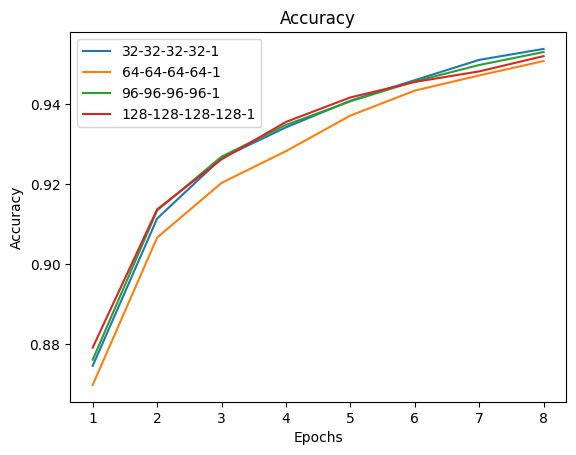

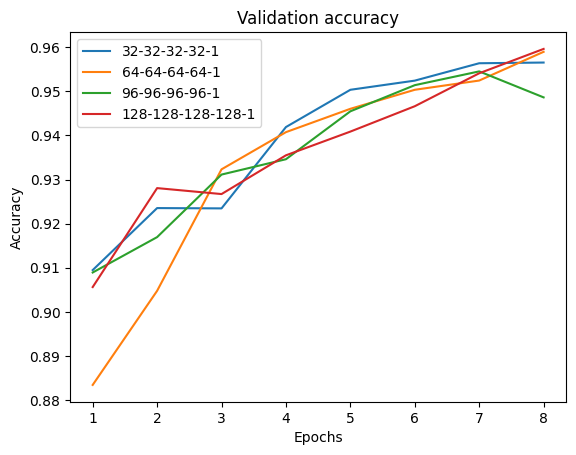

In [35]:
#declare networks according to "histories[model_name]"
net_a, net_b, net_c, net_d = '32-32-32-32-1', '64-64-64-64-1', '96-96-96-96-1', '128-128-128-128-1'
#plotting accuracy
plot_acc_comparison(acc_a=histories[net_a].history['accuracy'], label_a=net_a,
                     acc_b=histories[net_b].history['accuracy'], label_b=net_b,
                     acc_c=histories[net_c].history['accuracy'], label_c=net_c,
                    acc_d=histories[net_d].history['accuracy'], label_d=net_d,
                    #acc_e=histories[net_e].history['accuracy'], label_e=net_e, 
                    y_label='Accuracy')
#plotting validation accuracy
plot_val_acc_comparison(val_acc_a=histories[net_a].history['val_accuracy'], label_a=net_a,
                     val_acc_b=histories[net_b].history['val_accuracy'], label_b=net_b,
                     val_acc_c=histories[net_c].history['val_accuracy'], label_c=net_c,
                        val_acc_d=histories[net_d].history['val_accuracy'], label_d=net_d,
                        #val_acc_e=histories[net_e].history['val_accuracy'], label_e=net_e, 
                        y_label='Accuracy')

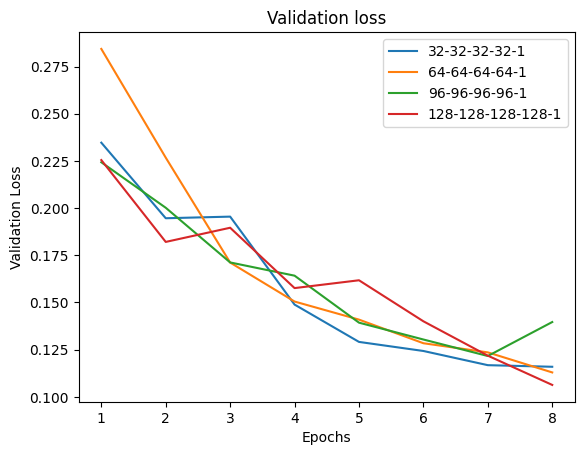

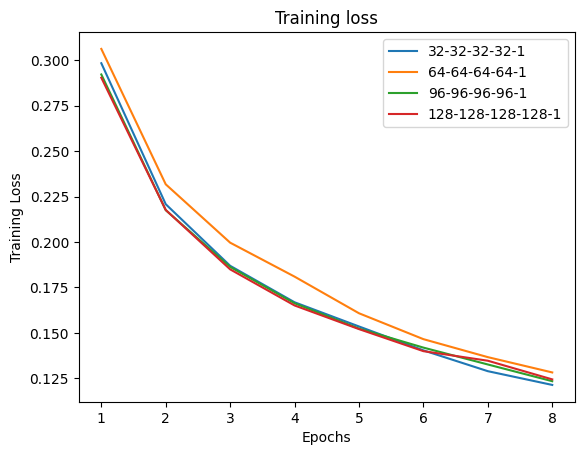

In [34]:
# plotting loss and validation loss
plot_loss_comparison(loss_a=histories[net_a].history['val_loss'], label_a=net_a,
                     loss_b=histories[net_b].history['val_loss'], label_b=net_b,
                     loss_c=histories[net_c].history['val_loss'], label_c=net_c,
                     loss_d=histories[net_d].history['val_loss'], label_d=net_d,
                     #loss_e=histories[net_e].history['val_loss'], label_e=net_e,
                        y_label='Validation Loss')

plot_training_loss_comparison(tloss_a=histories[net_a].history['loss'], label_a=net_a,
                     tloss_b=histories[net_b].history['loss'], label_b=net_b,
                     tloss_c=histories[net_c].history['loss'], label_c=net_c,
                    tloss_d=histories[net_d].history['loss'], label_d=net_d,
                    #tloss_e=histories[net_e].history['loss'], label_e=net_e,
                        y_label='Training Loss')

## Interpretation

Network D (96-96-96-96-1) looks like it is starting to overfit with more epochs, so let’s try to add more layers and run it again with more epochs (70). 

In [46]:
def build_model(layer_1_units, layer_2_units, layer_3_units, layer_4_units, layer_5_units, layer_6_units):
    model = Sequential()
# CNN layers     
    model.add(Conv2D(32, (3,3), strides=2, activation = 'relu', input_shape = (192, 144, 3)))
    model.add(MaxPooling2D((2,2))) 
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(96, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(96, (3,3),  padding = 'Same',  activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Flatten())
## Dense layers
    model.add(Dense(layer_1_units, activation = 'relu'))
    model.add(Dense(layer_2_units, activation = 'relu'))
    model.add(Dense(layer_3_units, activation = 'relu'))
    model.add(Dense(layer_4_units, activation = 'relu'))
    model.add(Dense(layer_5_units, activation = 'relu'))
    model.add(Dense(layer_6_units, activation = 'sigmoid'))
    #optimizers 
    model.compile(loss = 'binary_crossentropy', optimizer = "Adam", metrics = ['accuracy'])
    return model    

In [47]:
histories = {}

#can input number of hidden units for each layer. Here we will test an increasing large number of hidden units
for i in [96]:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model = build_model(i, i, i, i, i, 1)
    model_name = str(i) + '-' + str(i) + '-'+ str(i) + '-'+ str(i) + '-'+ str(i) +'-'+ str(1)
    print('Training', model_name)
    history = model.fit(batched_train_dataset,
                        epochs= 70,
                        validation_data=batched_val_dataset,
                        verbose = 0,
                        callbacks=[callback]
                       )
    histories[model_name] = history
    results = model.evaluate(batched_test_dataset)
    model.summary()
    #model.reset_states() 

Training 96-96-96-96-96-1
441/441 [==============================] - 45s 32ms/step - loss: 0.0160 - accuracy: 0.9945
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 95, 71, 32)        896       
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 47, 35, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 45, 33, 64)        18496     
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 22, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 22, 16, 96)        55392     
  

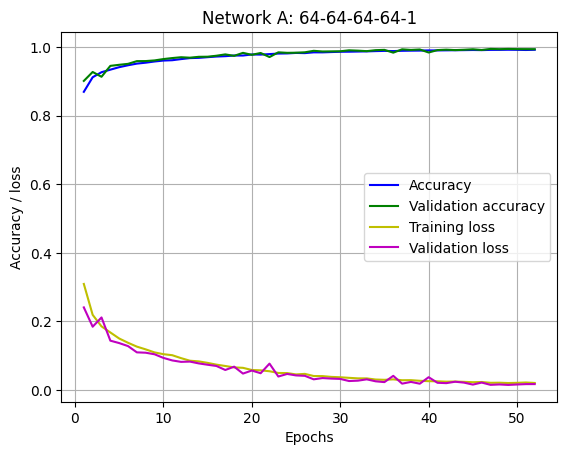

In [48]:
net_aof = '96-96-96-96-96-1'
plot_net_a(acc=histories[net_aof].history['accuracy'], label_a="Accuracy",
           val_acc=histories[net_aof].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_aof].history['loss'], label_c="Training loss",
            loss=histories[net_aof].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

## Interpretation

After around 53 epochs (stopped early because of no change in loss), it still looks like the network of interest is still not overfitting. Another try at overfitting the model with more layers and in the Conv2D and dense layers will be outlined below.

In [14]:
def build_model(layer_1_units, layer_2_units, layer_3_units, layer_4_units, layer_5_units, layer_6_units, layer_7_units, layer_8_units):
    model = Sequential()
# CNN layers     
    model.add(Conv2D(32, (3,3), strides=2, activation = 'relu', input_shape = (192, 144, 3)))
    model.add(MaxPooling2D((2,2))) 
    model.add(Conv2D(96, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(96, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(96, (3,3),  padding = 'Same',  activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Flatten())
## Dense layers
    model.add(Dense(layer_1_units, activation = 'relu'))
    model.add(Dense(layer_2_units, activation = 'relu'))
    model.add(Dense(layer_3_units, activation = 'relu'))
    model.add(Dense(layer_4_units, activation = 'relu'))
    model.add(Dense(layer_5_units, activation = 'relu'))
    model.add(Dense(layer_6_units, activation = 'relu'))
    model.add(Dense(layer_7_units, activation = 'relu'))
    model.add(Dense(layer_8_units, activation = 'sigmoid'))
    #optimizers 
    model.compile(loss = 'binary_crossentropy', optimizer = "Adam", metrics = ['accuracy'])
    return model    

In [15]:
histories = {}

#can input number of hidden units for each layer. Here we will test an increasing large number of hidden units
for i in [96]:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model = build_model(i, i, i, i, i, i, i ,1)
    model_name = str(i) + 'x' + str(7) + str(1)
    print('Training', model_name)
    history = model.fit(batched_train_dataset,
                        epochs= 60,
                        validation_data=batched_val_dataset,
                        verbose = 0,
                        callbacks=[callback]
                       )
    histories[model_name] = history
    results = model.evaluate(batched_test_dataset)
    model.summary()
    #model.reset_states() 




Training 96x71


441/441 [==============================] - 67s 51ms/step - loss: 0.0223 - accuracy: 0.9923
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 71, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 35, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 33, 96)        27744     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 16, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 16, 96)        83040     
           

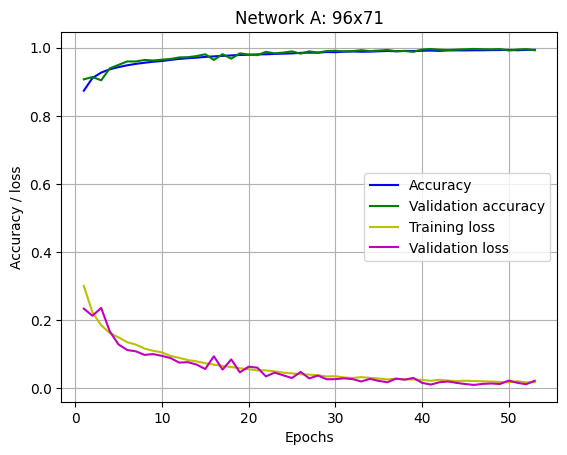

In [20]:
net_a = '96x71'

plot_net_a(acc=histories[net_a].history['accuracy'], label_a="Accuracy",
           val_acc=histories[net_a].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_a].history['loss'], label_c="Training loss",
            loss=histories[net_a].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

## Interpretation

After around 53 epochs again (stopped early because of no change in loss), the network of interest is still not overfitting. At this point overfitting does not look possible with the model and this dataset. It is possible that even more layers and more epochs, maybe in the hundreds, will cause the model to overfit, but in spirit of completeing the project, the author has decided to move on. 
***

## Building best performing model

Building on what was discovered during the previous section, we will try and make a minimum sized model that can acheive maximum accuracy. We will start with a slightly smaller network this time.

In [42]:
# define function that can run sequential models back to back

def build_model(layer_1_units, layer_2_units, layer_3_units, layer_4_units, layer_5_units):
    model = Sequential()
# CNN layers     
    model.add(Conv2D(32, (3,3), strides=2, activation = 'relu', input_shape = (192, 144, 3)))
    model.add(MaxPooling2D((2,2))) 
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(96, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3),  padding = 'Same',  activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(32, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Flatten())
## Dense layers
    model.add(Dense(layer_1_units, activation = 'relu'))
    model.add(Dense(layer_2_units, activation = 'relu'))
    model.add(Dense(layer_3_units, activation = 'relu'))
    model.add(Dense(layer_4_units, activation = 'relu'))
    model.add(Dense(layer_5_units, activation = 'sigmoid'))
    #optimizers 
    model.compile(loss = 'binary_crossentropy', optimizer = "Adam", metrics = ['accuracy'])
    return model    

In [43]:
histories = {}

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#can input number of hidden units for each layer. Here we will test an increasing large number of hidden units
for i in [64, 96]:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model = build_model(i, i, i, i, 1)
    model_name = str(i) + '-' + str(i) + '-'+ str(i) + '-'+ str(i) + '-'+ str(1)
    print('Training', model_name)
    history = model.fit(batched_train_dataset,
                        epochs= 25,
                        validation_data=batched_val_dataset,
                        verbose = 0,
                        callbacks=[callback, tensorboard_callback]]
                       )
    histories[model_name] = history
    results = model.evaluate(batched_test_dataset)
    model.summary()
    #model.reset_states() 

Training 64-64-64-64-1
441/441 [==============================] - 53s 38ms/step - loss: 0.0491 - accuracy: 0.9827
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 95, 71, 32)        896       
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 47, 35, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 45, 33, 64)        18496     
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 22, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 20, 14, 96)        55392     
     

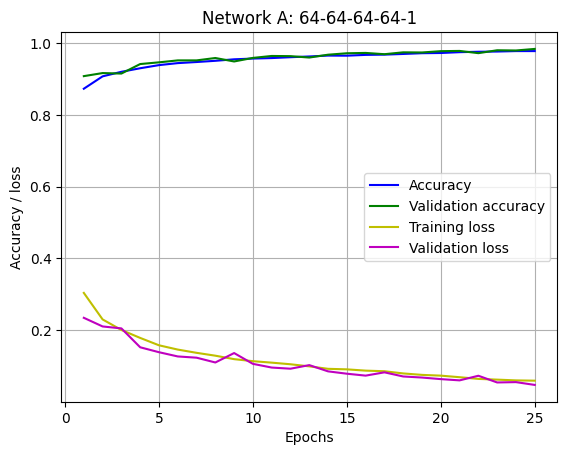

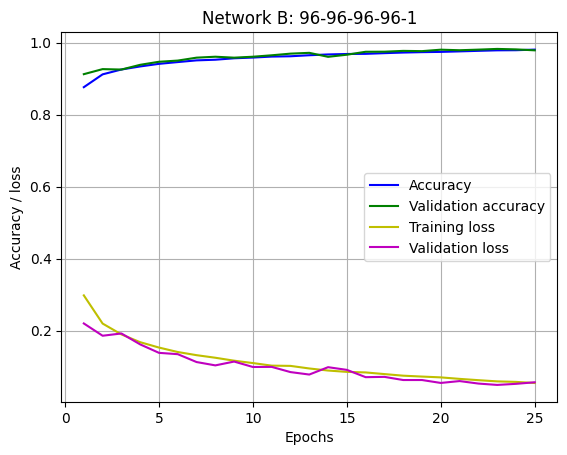

In [45]:
net_a, net_b = '64-64-64-64-1', '96-96-96-96-1'

plot_net_a(acc=histories[net_a].history['accuracy'], label_a="Accuracy",
           val_acc=histories[net_a].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_a].history['loss'], label_c="Training loss",
            loss=histories[net_a].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

plot_net_b(acc=histories[net_b].history['accuracy'], label_a="Accuracy",
           val_acc=histories[net_b].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_b].history['loss'], label_c="Training loss",
            loss=histories[net_b].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')


### Larger model
More layers and more units per layer will be tested again to see if we can improve on accuracy. This will be based on the attempt at model overfitting.

In [22]:
# define function that can run sequential models back to back

def build_model(layer_1_units, layer_2_units, layer_3_units, layer_4_units, layer_5_units, layer_6_units):
    model = Sequential()
# CNN layers     
    model.add(Conv2D(32, (3,3), strides=2, activation = 'relu', input_shape = (192, 144, 3)))
    model.add(MaxPooling2D((2,2))) 
    model.add(Conv2D(96, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(96, (3,3), padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(96, (3,3),  padding = 'Same',  activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(64, (3,3),  padding = 'Same', activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Flatten())
## Dense layers
    model.add(Dense(layer_1_units, activation = 'relu'))
    model.add(Dense(layer_2_units, activation = 'relu'))
    model.add(Dense(layer_3_units, activation = 'relu'))
    model.add(Dense(layer_4_units, activation = 'relu'))
    model.add(Dense(layer_5_units, activation = 'relu'))
    model.add(Dense(layer_6_units, activation = 'sigmoid'))
    #optimizers 
    model.compile(loss = 'binary_crossentropy', optimizer = "Adam", metrics = ['accuracy'])
    return model    

In [24]:
histories = {}

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#can input number of hidden units for each layer. Here we will test an increasing large number of hidden units
for i in [64]:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model = build_model(i, i, i, i, i, 1)
    model_name = str(i) + '-' + str(i) + '-'+ str(i) + '-'+ str(i) + '-'+ str(i) + '-'+ str(1)
    print('Training', model_name)
    history = model.fit(batched_train_dataset,
                        epochs= 35,
                        validation_data=batched_val_dataset,
                        verbose = 0,
                        callbacks=[callback, tensorboard_callback]
                       )
    histories[model_name] = history
    results = model.evaluate(batched_test_dataset)
    #model.summary()
    #model.reset_states() 

Training 64-64-64-64-64-1
441/441 [==============================] - 57s 43ms/step - loss: 0.0213 - accuracy: 0.9926


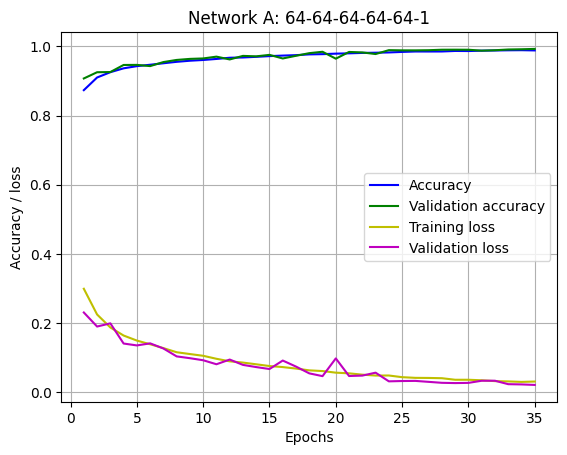

In [25]:
net_a = '64-64-64-64-64-1'
plot_net_a(acc=histories[net_a].history['accuracy'], label_a="Accuracy",
           val_acc=histories[net_a].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_a].history['loss'], label_c="Training loss",
            loss=histories[net_a].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

## Interpretation and conclusion

The results of this model is quite good and is able to reach 99.26% accuracy which is really good. Adding compleixity to the layers also allowed around 1% improvement over the best result from the previous iteration. 

In conclusion, this network is believed to be best performing model that is not too large.

***